## Gradient Descent Model for locating the base station

In [2]:
from wcscore import WCsimEnvCore
import matplotlib.pyplot as plt # plot
from mpl_toolkits import mplot3d # 3D plot
import numpy as np

In [115]:
np.random.seed(0) # initialize random seed

## Environment Setup

In [116]:
env = WCsimEnvCore(server_ip='127.0.0.1', server_port=8877)

Server: Hello Client~ 
Connected to Server successfully.
The Simulator is ready.


## Generate Base Station and Users

In [117]:
env.reset()

# Add a station
env.add_station([0, 7, 0], [0,0,0], 2.4e9)
stations = env.ask_stations_info()
station_id = stations[0] 

# Add Users
n_user = 100
for i in range(n_user):
    while True:
        random_position = list(np.multiply(np.random.rand(3), [200, 2, 200]) + [-100, 1, -100])
        env.add_user(random_position)
        user_id = env.ask_users_info()[-1]
        env.connect_user_to_station(station_id, user_id)
        if env.ask_user_info(user_id)['path loss'] != None:
            break
   
    
# Get list of users
user_ids = env.ask_users_info()
for user_id in user_ids:
    print(env.ask_user_info(user_id))

{'id': 0, 'position': [9.762701, 2.430379, 20.552675], 'station': 0, 'path loss': -66.082077}
{'id': 1, 'position': [8.976637, 1.84731, 29.178823], 'station': 0, 'path loss': -68.262436}
{'id': 2, 'position': [-12.482558, 2.783546, 92.732552], 'station': 0, 'path loss': -118.230667}
{'id': 3, 'position': [-23.311695, 2.58345, 5.778984], 'station': 0, 'path loss': -66.456558}
{'id': 4, 'position': [13.608912, 2.851193, -85.792786], 'station': 0, 'path loss': None}
{'id': 5, 'position': [-82.574142, 1.040437, 66.523972], 'station': 0, 'path loss': -115.440071}
{'id': 6, 'position': [55.631351, 2.740024, 95.723671], 'station': 0, 'path loss': -78.704758}
{'id': 7, 'position': [59.831715, 1.922959, 56.105835], 'station': 0, 'path loss': None}
{'id': 8, 'position': [-76.345116, 2.279842, -71.329346], 'station': 0, 'path loss': None}
{'id': 9, 'position': [88.933784, 2.043697, -17.067612], 'station': 0, 'path loss': -115.271416}
{'id': 10, 'position': [-47.088879, 2.548467, -8.769934], 'stat

{'id': 90, 'position': [95.499031, 2.75301, -32.36821], 'station': 0, 'path loss': -118.536896}
{'id': 91, 'position': [92.314034, 1.463403, 89.863762], 'station': 0, 'path loss': -120.795654}
{'id': 92, 'position': [88.275543, 2.598405, 26.089586], 'station': 0, 'path loss': -116.582275}
{'id': 93, 'position': [74.85759, 1.586041, 69.788712], 'station': 0, 'path loss': -119.827927}
{'id': 94, 'position': [23.575338, 1.026474, -30.553295], 'station': 0, 'path loss': -70.027992}
{'id': 95, 'position': [-70.371826, 2.963659, -4.325939], 'station': 0, 'path loss': None}
{'id': 96, 'position': [-0.521727, 2.278945, -26.283079], 'station': 0, 'path loss': -67.064713}
{'id': 97, 'position': [-72.619949, 2.644235, -62.030418], 'station': 0, 'path loss': -92.138779}
{'id': 98, 'position': [2.263797, 1.448634, -80.431107], 'station': 0, 'path loss': -113.584946}
{'id': 99, 'position': [72.438301, 2.945839, 92.166931], 'station': 0, 'path loss': -120.602203}
{'id': 100, 'position': [81.311096, 2

In [ ]:
for user_id in user_ids:
    print(env.ask_user_info(user_id))

In [ ]:
# MVP for first model
itr = 100
step_rate = 1
ep = 0.001
avg_pl_list = [env.ask_station_info(station_id)['average path loss']]
x_list = [env.ask_station_info(station_id)['position'][0]]
z_list = [env.ask_station_info(station_id)['position'][2]]

for i in range(itr):
    station = env.ask_station_info(station_id)
    position = station['position']
    rotation = station['rotation']
    
    pos_x_plus_ep = list(np.array(position) + [ep, 0, 0])
    pot_x_min_ep = list(np.array(position) - [ep, 0, 0])
    pos_z_plus_ep = list(np.array(position) + [0, 0, ep])
    pot_z_min_ep = list(np.array(position) - [0, 0, ep])
    
    # f_x_plus
    env.move_station_to(station_id, pos_x_plus_ep, rotation)
    x_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if x_plus_ep_pl == None:
        x_plus_ep_pl = -500
    # f_x_min
    env.move_station_to(station_id, pot_x_min_ep, rotation)
    x_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if x_min_ep_pl == None:
        x_min_ep_pl = -500
    
    # f_x_plus
    env.move_station_to(station_id, pos_z_plus_ep, rotation)
    z_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if z_plus_ep_pl == None:
        z_plus_ep_pl = -500
    # f_z_min
    env.move_station_to(station_id, pot_z_min_ep, rotation)
    z_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if z_min_ep_pl == None:
        z_min_ep_pl = -500
    
    # Calculate dx
    dx = (x_plus_ep_pl - x_min_ep_pl)/(2*ep)
    dz = (z_plus_ep_pl - z_min_ep_pl)/(2*ep)
    
    if np.round(dx, 10) == 0:
        break
    if np.round(dz, 10) == 0:
        break
    # update position + because step up to local max since pl are minus
    position = list(np.array(position) + [dx*step_rate, 0, dz*step_rate])
    env.move_station_to(station_id, position, rotation)
    improved_pl =  env.ask_station_info(station_id)['average path loss']
    avg_pl_list.append(improved_pl)
    x_list.append(env.ask_station_info(station_id)['position'][0])
    z_list.append(env.ask_station_info(station_id)['position'][2])
    print(improved_pl)

In [120]:
station_id = stations[0]
heat_map = []

for x in range(-100,100,2):
    z_row = []
    for z in range(-100,100,2):
        position = [x, 7, z]
        env.move_station_to(station_id, position, [0, 0, 0])
        avg_pl = env.ask_station_info(station_id)['average path loss']
        if avg_pl is None:
            avg_pl = -200
        z_row.append(avg_pl)
    heat_map.append(z_row)
    
plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.show()

ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [ ]:
store_heat_map = np.array(heat_map)
np.savez_compressed('new.npz', heat_map = store_heat_map)

In [3]:
data = np.load('./heat_map.npz', 'r')
heat_map = data['arr_0']

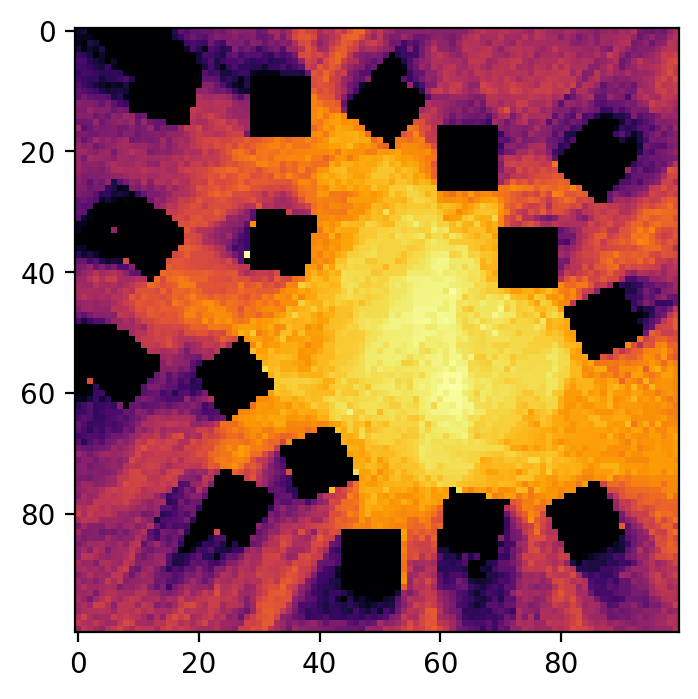

In [4]:
max_l = -140
heat_map[heat_map < max_l] = max_l
heat_map[heat_map > -80.22] = max_l 
plt.rcParams['figure.dpi'] = 200
plt.imshow(heat_map, cmap='inferno', interpolation='nearest')
plt.show()

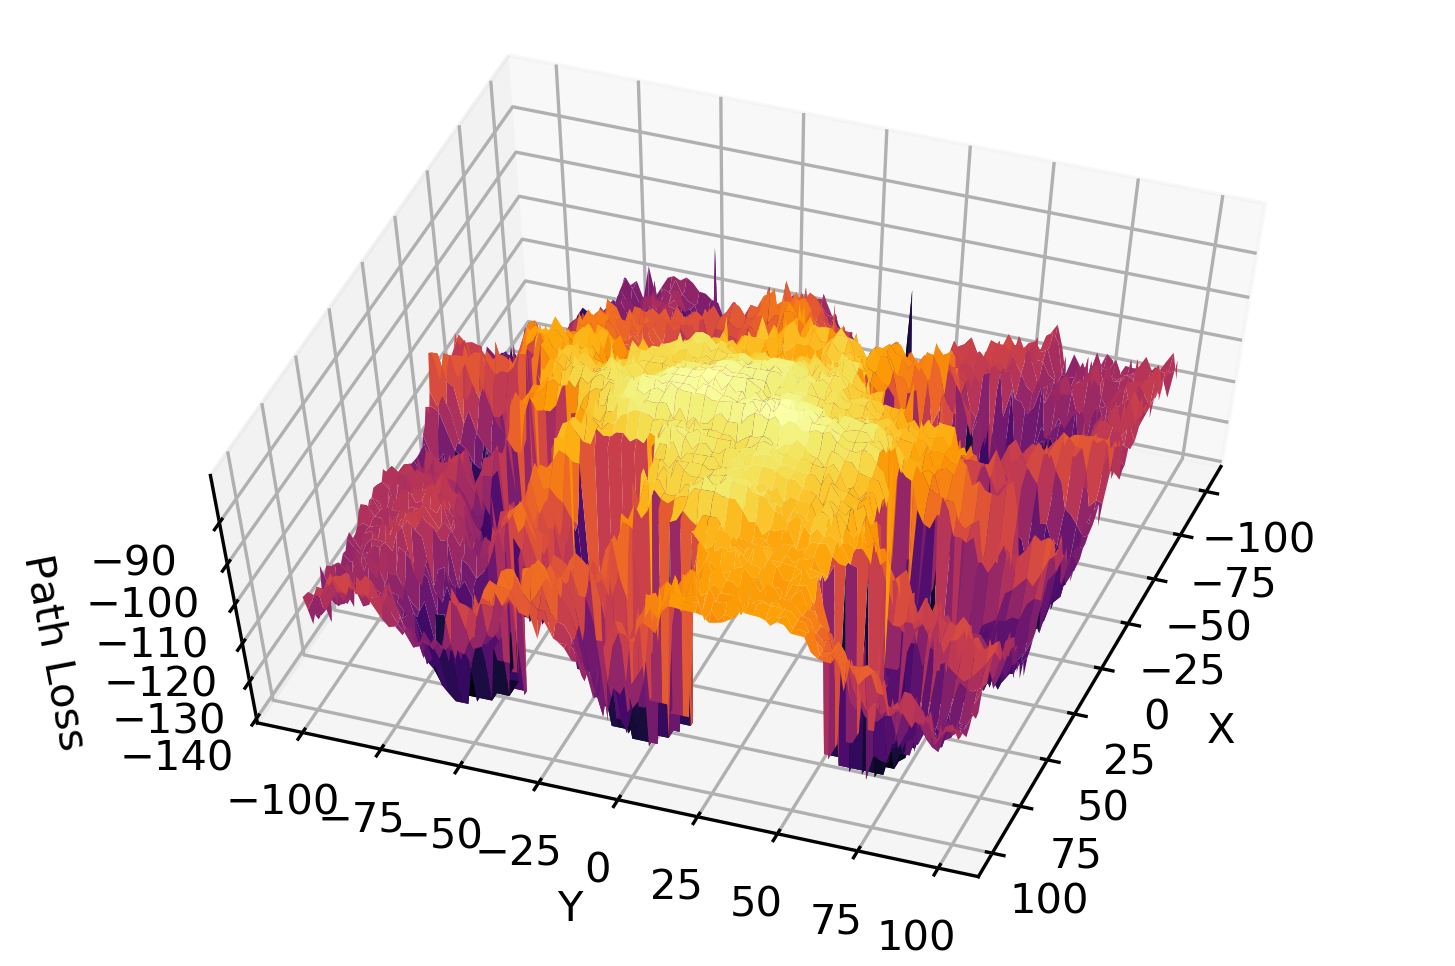

In [28]:
ax = plt.axes(projection='3d')

x = range(-100,100,2)
z = range(-100,100,2)
heat_map_cop = np.array(heat_map)
#y = heat_map_cop/np.linalg.norm(heat_map_cop)
y = heat_map_cop.reshape((100,100))
#y = np.abs(y)
X,Z = np.meshgrid(x,z)
#y = np.abs(y)
ax.plot_surface(X, Z, y, cmap='inferno')
plt.rcParams['figure.dpi'] = 300
ax.set_zlabel('Path Loss')
ax.view_init(60, 20)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [103]:
heat_map

array([[-135.440033, -134.193512, -140.      , ..., -121.368576,
        -116.65258 , -112.536751],
       [-136.412521, -136.569702, -137.245102, ..., -119.249603,
        -113.913452, -110.867081],
       [-137.195694, -139.404434, -132.322266, ..., -116.911171,
        -110.20816 , -111.445892],
       ...,
       [-112.048981, -107.004608, -112.522034, ..., -114.538971,
        -112.289772, -112.284149],
       [-109.371529, -111.907593, -112.644943, ..., -113.684143,
        -111.268761, -112.251221],
       [-115.564484, -110.067665, -111.708061, ..., -115.36792 ,
        -114.940536, -111.417526]])

In [ ]:
len(y_list)

In [ ]:
final_position =  env.ask_station_info(station_id)['position']
final_position

In [ ]:
for user_id in user_ids:
    print(env.ask_user_info(user_id))

In [88]:
env.disconnect()